## Import Libs

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import joblib

2024-07-11 22:07:09.599659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 22:07:09.619390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 22:07:09.619422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 22:07:09.632128: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 22:07:10.517195: W tensorflow/compiler/tf

### Import Dataset

In [4]:
import os

# Construct the absolute file path
file_path = '../dataset/Product_Explanation.txt'
# Initialize lists to store the parsed data
product_ids = []
descriptions = []

with open(file_path, 'r') as file:
    for line in file:  # Adjust the range to read more lines if needed
        #print(line)
        product_id, description = line.strip().split(';', 1)
        #print(product_id ,"+", description)
        product_ids.append(product_id)
        descriptions.append(description)
print(len(product_ids))
# Open and read the file

1800


In [5]:
file_path = '../dataset/Product_Categories.txt'

# Initialize lists to store the parsed data
categories = []
turkish_lower_mapping = str.maketrans('İI', 'ii')

with open(file_path, 'r') as file:
    for line in file:  # Adjust the range to read more lines if needed
        #print(line)
        _, category = line.strip().split(';', 1)
        category = category.strip()
        category_list = category.split(" > ")
        category = []
        for cat in category_list:
            cat = cat.lower().translate(turkish_lower_mapping)#lower with turkhish chars
            cat = cat.strip()#to remove empty char
            if cat != "":
                category.append(cat)
        #print(category)
        categories.append(category)
        
print(len(categories))

1800


make a list of category for each product

### Remove dublicates in categories

First we need to take a look at all category names

In [6]:
#Flatten the category list
flat_list = [item for sublist in categories for item in sublist]

#find unique category

from collections import Counter

unique_categories = list(set(flat_list))
counter = Counter(flat_list)
counter

Counter({'bilgisayar': 462,
         'bilgisayar bileşenleri': 145,
         'çevre birimleri': 110,
         'bilgisayar ürünleri': 71,
         'telefon': 70,
         'aksesuar ürünleri': 66,
         'kablolar': 64,
         'tüketici elektroniği': 62,
         'oyunlar': 58,
         'tüketim malzemeleri': 52,
         'oem ürünleri': 50,
         'kartuş': 49,
         'samsung': 40,
         'televizyon': 38,
         'bilgisayarlar': 37,
         'mouse': 36,
         'monitörler': 36,
         'veri depolama': 35,
         'cep telefonları': 34,
         'cep telefonu': 34,
         'bilgisayar tablet yazıcı': 32,
         'elektronik': 31,
         'asus': 30,
         'toner': 30,
         'aksesuarlar': 30,
         'resim': 29,
         'monitör': 28,
         'pc': 28,
         'yazıcılar': 28,
         'tablet': 27,
         'televizyonlar': 26,
         'bi̇lgi̇sayar': 26,
         'küçük ev aletleri': 25,
         's-link': 25,
         'sarf malzemeleri': 25,
        

* "bilgisayar bileşenleri" + "bilgisayar ürünleri" + "oem ürünleri" + "oem & çevre birimleri" + "bilgisayar bileşenleri (oem)"
* "çevre birimleri" + "bilgisayar parçaları" + "çevre birimi"
* "televizyon" + "televizyonlar" + "led TV" + "tv & görüntü sistemleri"
* "pc" + "bilgisayar" + "Kişisel Bilgisayarlar"
* "yazılım ürünleri" + "Yazılım ve Hizmetler" + "Yazılım"
* "Hobi & Oyun Konsolları" + "Oyun & Oyun Konsolu" + "oyun - hobi"
* "hafıza kartları" + "hafıza kartı"


Since those categories mostly not different then other, we can merge them

In [7]:
remove_list = [
    ["bilgisayar bileşenleri", "bilgisayar ürünleri", "oem ürünleri", "oem & çevre birimleri", "bilgisayar bileşenleri (oem)", "oem"],
    ["çevre birimleri", "bilgisayar parçaları", "çevre birimi"],
    ["televizyon", "televizyonlar", "led tv", "tv & görüntü sistemleri"],
    ["bilgisayar", "pc", "kişisel bilgisayarlar", "bilgisayarlar", "bi̇lgi̇sayar"],
    ["yazılım","yazılım ürünleri", "yazılım ve hizmetler"],
    ["oyun - hobi","hobi & oyun konsolları", "oyun & oyun konsolu"],
    ["hafıza kartları", "hafıza kartı"],
    ["ütü","ütüler"],
    ["ekran kartı", "ekran kartları"],
    ["monitör", "monitörler"],
    ["yazıcılar",'yazıcı/tarayıcı/fax',"yazıcı"],
    ['cep telefonu','cep telefonları','telefon']
]

for sublist in categories:
        for i in range(len(sublist)):
            for j in range(len(remove_list)):
                if sublist[i] in remove_list[j]:
                        sublist[i] = remove_list[j][0]
        sublist = list(set(sublist))

            

## Create Data Frame

In [8]:
# creating dataframe with three rows (name,description,categories)
column_names = ['id','description','categories']
df = pd.DataFrame(columns = column_names)

In [9]:
df = pd.DataFrame(list(zip(product_ids,descriptions,categories)) ,columns = column_names)
df = df.dropna(subset=['description'])  # Drop rows where 'description' is NaN
df = df[df['description'] != ''] 
df = df[df['description'] != 'null'] 

# Reset index
df = df.reset_index(drop=True)
df

,id,description,categories
0,462,HP Pavilion 11-n000nt Pentium N3540 4GB 750GB ...,"[bilgisayar, taşınabilir bilgisayarlar]"
1,1286,STOKTAN AYNI GÜN TESLİM AYNI GÜN KARGO iPhone ...,"[cep telefonu, apple]"
2,1290,Ağırlık (Gr.) 115 Boyut (mm.) 132.4 x 65.5 x 6...,"[cep telefonu, samsung]"
3,1300,"ÖZELLİKLER Ekran Ekran Boyutu 48"" Ekran Boyutu...","[ev elektroniği, televizyon, samsung]"
4,1665,Ürün Kodu : 40061255166 Genel Özellikler Panel...,"[bilgisayar, çevre birimleri, monitör, led mon..."
...,...,...,...
1477,1040055,Powersupply Gücü :550WGaranti Süresi :24 Ay,[cooler master 550w rs550-80gaj3-eu güç kaynağı]
1478,1040520,Baskı Rengi :MaviYazdırma Teknolojisi :LaserBa...,[canon crg-731c toner kartuş mavi]
1479,1040521,Baskı Rengi :KırmızıYazdırma Teknolojisi :Lase...,[canon crg-731m toner kartuş kırmızı]
1480,1040676,Disk Kapasite Aralığı :2 TB - 4 TBGaranti Süre...,[zyxel nsa-325 2x4tb disk destekli depolama ün...


There are total 1482 products listed in the product.json file. As each instanse can belong to multiple categories, so these types of problems are known as multi-label classification problem, where we have a set of target labels. If there are multiple categories but each instance is assigned only one, therefore such problems are known as multi-class classification problem.

In [10]:
cat = pd.DataFrame(df['categories'].to_list()) # listing the categories seperately
cat.head()

,0,1,2,3,4
0,bilgisayar,taşınabilir bilgisayarlar,None,None,None
1,cep telefonu,apple,None,None,None
2,cep telefonu,samsung,None,None,None
3,ev elektroniği,televizyon,samsung,None,None
4,bilgisayar,çevre birimleri,monitör,led monitörler,philips


In [11]:

# finding total unique categories/classes from which our prediction will belong too
category_0 = cat[0].unique()
category_1 = cat[1].unique()
category_2 = cat[2].unique()
category_3 = cat[3].unique()
category_4 = cat[4].unique()

cates = np.concatenate([category_0, category_1, category_2,category_3,category_4])
cates = list(dict.fromkeys(cates))
cates = [x for x in cates if x is not None] # remove None
len(cates) # number of unique classes/categories

928

In [12]:
cat = pd.concat([cat,pd.DataFrame(columns = list(cates))]) # concatnate categories/classes to original dataframe
cat.fillna(0, inplace = True) # fill with zero
cat.head()

/tmp/ipykernel_91261/3831650490.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cat.fillna(0, inplace = True) # fill with zero


,0,1,2,3,4,bilgisayar,cep telefonu,ev elektroniği,pc / monitör,bilgisayar bileşenleri,...,kırtasiye ürünleri,hdmi kablolar,yazıcı kartuşları,x360 medal of honor warfighter,kablosuz,monitör - led,klavye-mouse takımı,western digital,macera-aksiyon,null
0,bilgisayar,taşınabilir bilgisayarlar,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,cep telefonu,apple,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cep telefonu,samsung,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ev elektroniği,televizyon,samsung,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,bilgisayar,çevre birimleri,monitör,led monitörler,philips,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:


# filling attendence for all the categories/classes
for i in range(5):
  row = 0
  for category in cat[i]:
    if category!= 0:
      cat.loc[row,category] = 1 # loc is label-based, which means that you have to specify rows and columns based on their row and column labels.
    row = row + 1
# iloc is integer position-based, so you have to specify rows and columns by their integer position values (0-based integer position)
     
cat.head()

,0,1,2,3,4,bilgisayar,cep telefonu,ev elektroniği,pc / monitör,bilgisayar bileşenleri,...,kırtasiye ürünleri,hdmi kablolar,yazıcı kartuşları,x360 medal of honor warfighter,kablosuz,monitör - led,klavye-mouse takımı,western digital,macera-aksiyon,null
0,bilgisayar,taşınabilir bilgisayarlar,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,cep telefonu,apple,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cep telefonu,samsung,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ev elektroniği,televizyon,samsung,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,bilgisayar,çevre birimleri,monitör,led monitörler,philips,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:

df2 = pd.concat([df['id'],df['description'],cat.loc[:,"bilgisayar":]],axis=1) # creating new dataframe which contains name of product,description and categories it belong to
df2.head()
     

,id,description,bilgisayar,cep telefonu,ev elektroniği,pc / monitör,bilgisayar bileşenleri,fotoğraf / elektronik,küçük ev aletleri,televizyon,...,kırtasiye ürünleri,hdmi kablolar,yazıcı kartuşları,x360 medal of honor warfighter,kablosuz,monitör - led,klavye-mouse takımı,western digital,macera-aksiyon,null
0,462,HP Pavilion 11-n000nt Pentium N3540 4GB 750GB ...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1286,STOKTAN AYNI GÜN TESLİM AYNI GÜN KARGO iPhone ...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1290,Ağırlık (Gr.) 115 Boyut (mm.) 132.4 x 65.5 x 6...,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1300,"ÖZELLİKLER Ekran Ekran Boyutu 48"" Ekran Boyutu...",0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1665,Ürün Kodu : 40061255166 Genel Özellikler Panel...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df2.shape

(1482, 930)

# Data Analysis

In [16]:
bar_plot = pd.DataFrame()
bar_plot['category'] = df2.columns[2:] # column name, which are categories
bar_plot['count'] = df2.iloc[:,2:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head() # Top 5 most occuring categories

,category,count
0,bilgisayar,422
1,bilgisayar bileşenleri,239
2,çevre birimleri,129
3,cep telefonu,92
4,aksesuar ürünleri,66


/tmp/ipykernel_91261/4025590722.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bar_plot['category'][:100], y=bar_plot['count'][:100], palette=np.array(pal[::-1])[rank])
/tmp/ipykernel_91261/4025590722.py:10: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=bar_plot['category'][:100], y=bar_plot['count'][:100], palette=np.array(pal[::-1])[rank])
/tmp/ipykernel_91261/4025590722.py:10: UserWarning: The palette list has more values (928) than needed (100), which may not be intended.
  sns.barplot(x=bar_plot['category'][:100], y=bar_plot['count'][:100], palette=np.array(pal[::-1])[rank])


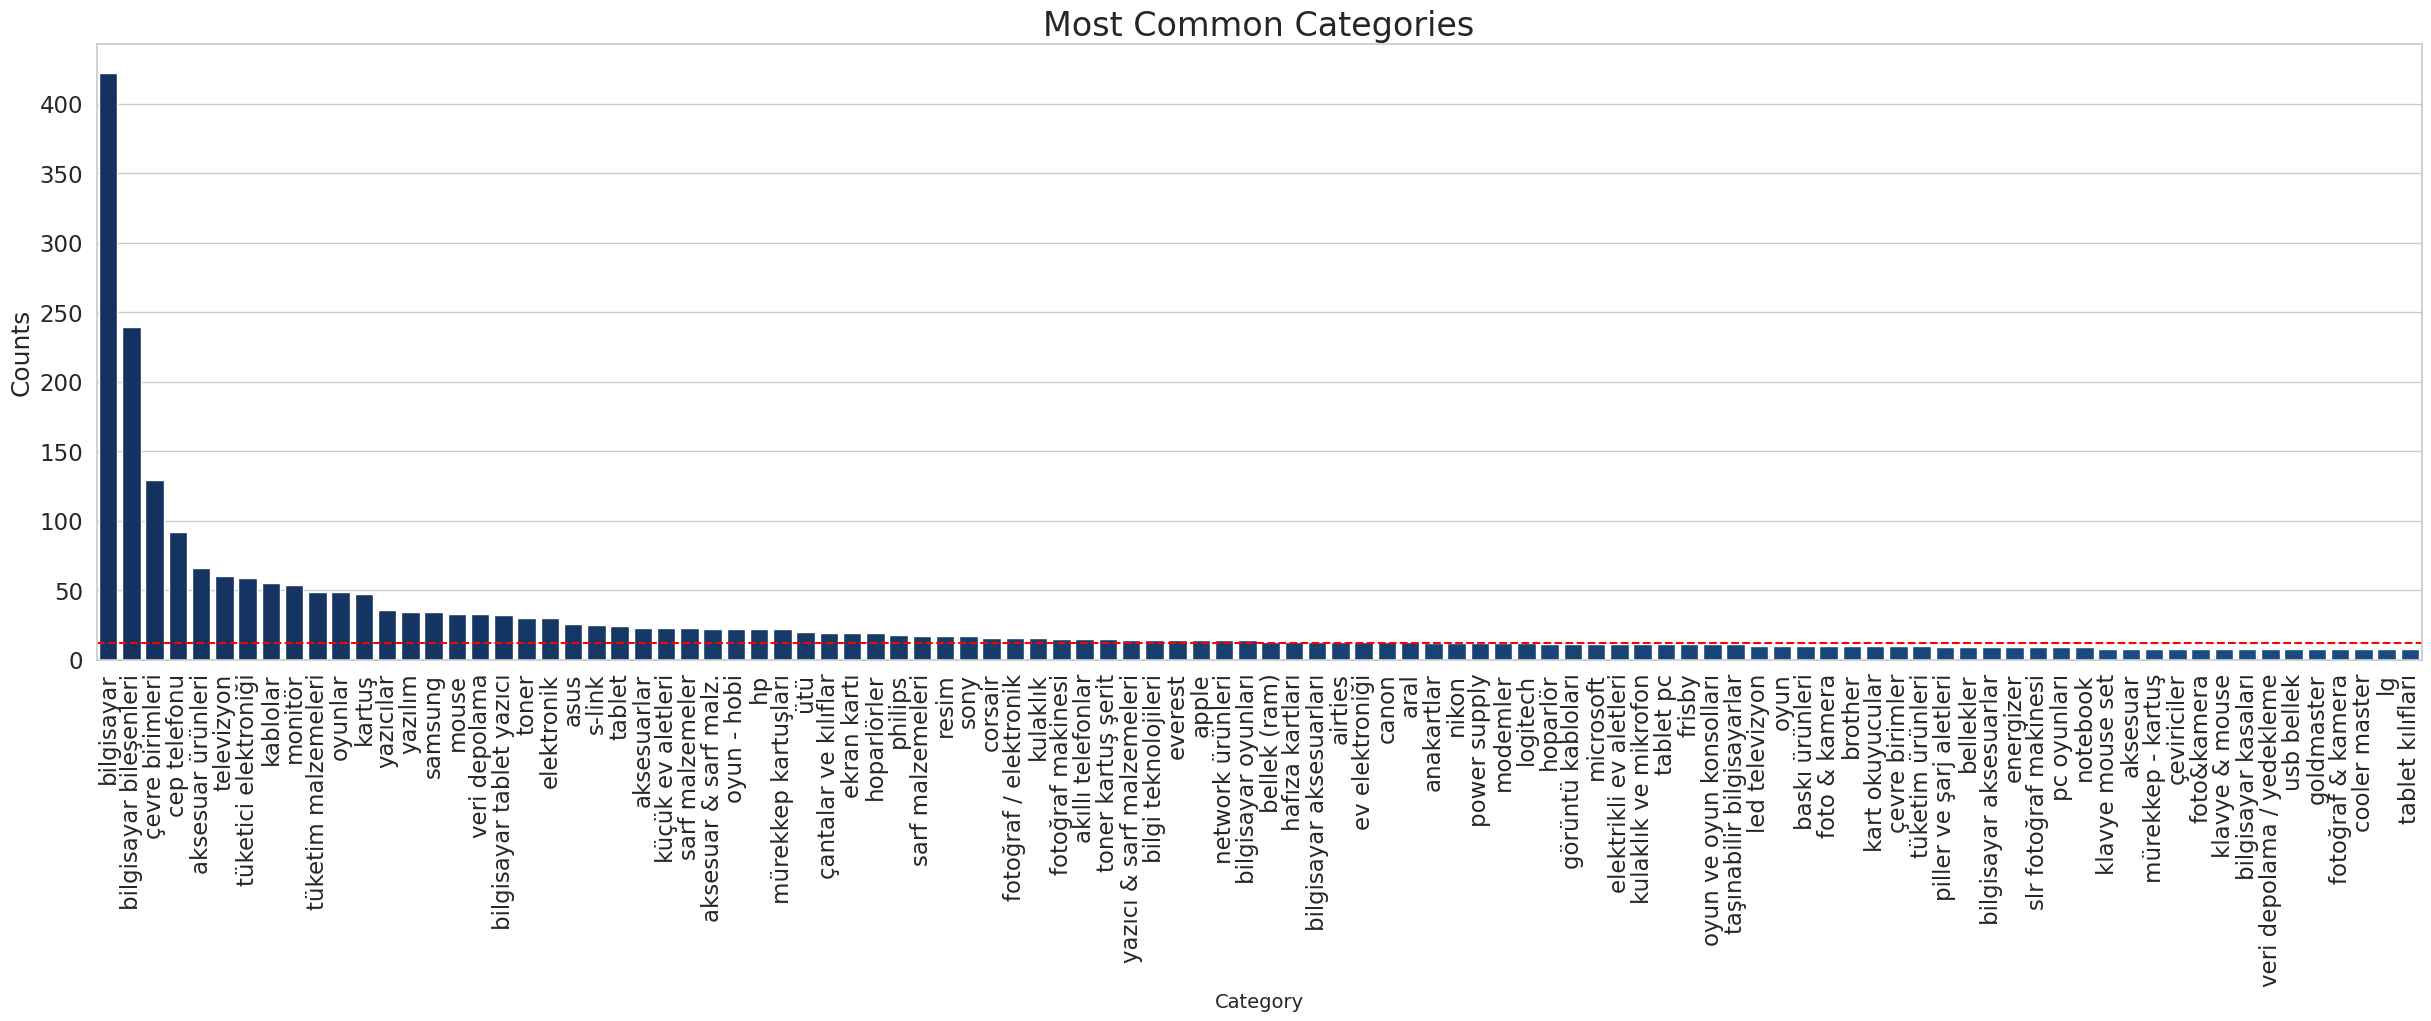

In [17]:
threshold = 12  # Trashold value

plt.figure(figsize=(30, 8))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

pal = sns.color_palette("Blues_r", len(bar_plot))
rank = bar_plot['count'].argsort().argsort()

sns.barplot(x=bar_plot['category'][:100], y=bar_plot['count'][:100], palette=np.array(pal[::-1])[rank])
plt.axhline(threshold, ls='--', c='red')
plt.title("Most Common Categories", fontsize=24)
plt.ylabel('Counts', fontsize=18)
plt.xlabel('Category', fontsize=14)
plt.xticks(rotation='vertical')
plt.show()


I want to chose trashold value as 12, because the categories with lower than 12 is very sprecific categories. Therefore, we can ignore them.

In [18]:
threshold = 12 

warnings.filterwarnings('ignore')

main_categories = pd.DataFrame()
main_categories = bar_plot[bar_plot['count']>threshold]
categories = main_categories['category'].values
categories = np.append(categories,'Others')
not_category = []
df2['Others'] = 0

for i in df2.columns[2:]:
    if i not in categories:
        df2['Others'][df2[i] == 1] = 1
        not_category.append(i)

df2.drop(not_category, axis=1, inplace=True)

df2.shape

(1482, 60)

We decrease the number of classes from 930 to 60. 

In [19]:
category_count = ['Category 0', 'Category 1', 'Category 2', 'Category 3','Category 4']
num_products = [0, 0, 0, 0,0,0,0, 0,0,0,0]

for i in range(len(categories)):
    print((categories[i]))
    num_products[len(categories[i])] += 1

bilgisayar
bilgisayar bileşenleri


IndexError: list index out of range

## Data Cleaning

### Remove Stop Words for Turkish

Let's create a funciton for removing stop words. Since our descriptions are Turkish, I use different library that finds Turkish stop words. 

Main source of list is: https://github.com/sgsinclair/trombone/blob/master/src/main/resources/org/voyanttools/trombone/keywords/stop.tr.turkish-lucene.txt

In [20]:
dictionary = {}


# lisans bilgisini de barindaridan sozluk dosyasini ac
with open("dosyalar/derlemtr2016-10000.txt", 'r', encoding = 'utf-8') as fdict:
	for line in fdict:
		# lisansa ait olan satirlari yoksay ve bos satirlari atla
		if (line[0] not in ['0', '1']):
			continue

		freq, word = line.strip().split()
		dictionary[word] = int(freq)


def is_stop_word(word):
	
	return word in dictionary.keys()

def removeStopWords(sentence):
    words = sentence.split(" ")
    for word in words:
        if is_stop_word(word):
            words.remove(word)
    return " ".join(words)

In [21]:
text = ["Mahkemenin","bu","kararında", "kadına","yönelik","şiddetin",
"toplumda","oluşturduğu","rahatsızlığın", "etkili","olduğu", "bilgisayarı"]

textt = "Merhabalar ben Alperen Ovak, Kendimi geliştirmeyi ve yeni şeyler öğrenmeyi severim"

text_zeyrek = []

In [22]:
removeStopWords(textt)

'Merhabalar Alperen Ovak, Kendimi geliştirmeyi yeni öğrenmeyi'

In [23]:

def keepAlphaTurkish(sentence):
    sentence = str(sentence)
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-zA-ZçğıöşüÇĞİÖŞÜ]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    alpha_sent = re.sub(r'\s+', ' ', alpha_sent).strip()
    return alpha_sent

### Stemming for Turkish

In [24]:
from zeyrek import MorphAnalyzer
import nltk #bu ve bunun altındaki satırı punkt kütüphaneniz yüklü ise kapatabilirsiniz.
import logging
#nltk.download("punkt")

logging.basicConfig(level=logging.ERROR)
for logger_name in logging.root.manager.loggerDict:
    logging.getLogger(logger_name).setLevel(logging.ERROR)

counter = 0

def stemming(sentence):
    #global counter  # Declare that we are using the global counter variable
    #print(counter)
    #counter += 1  # Increase the value of counter
    zeyrek = MorphAnalyzer()
    result = []
    words = sentence.split(" ")
    result = []
    for index in range(len(words)):
        try: # incase of list out range error
            result.append(zeyrek.lemmatize(words[index])[0][1][0])
        except:
            result.append(words[index])

    return " ".join(result)
    

In [25]:
def cleanPunc(sentence): 
    sentence = str(sentence)
    cleaned = re.sub(r'[?|!|\'|"|#|-|®|™]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|:|;|"|(|\|/|-]',r' ',cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

In [26]:
a ="hp pavilion 11-n000nt pentium n3540 4gb 750gb 11 6 dokunmatik win8 - k0w08ea detay i̇şletim : 8i̇şlemci : intel® pentium® işlemcii̇şlemci : intel® pentium® n3540 intel hd graphics  2 16 ghz  2 mb önbellek  4 çekirdekli bellek: 4gb 1600 mhz ddr3l sdramdahili : 750 gb 5400 rpm sataekran : 29 5  11 6 inç  diyagonal hd led aydınlatmalı dokunmatik  1366 768 grafik : intel hd graphicsbağlantı noktaları1 hdmi1 usb 2 01 usb 3 01 rj-45ses özellikleri: 2 hoparlörlü beats audio™ağ arabirimitümleşik 10 100 base-t ethernet lankablosuz802 11b  1x1  bluetooth® 4 0 birleşimi  miracast türü: 45 ac adaptörüpil : 2 hücreli  29 wh prizmatikenerji verimliliğienergy star® belgeliepeat® silver"
b = cleanPunc(a)
c = keepAlphaTurkish(b)
d = removeStopWords(c)
e = stemming(d)
e

'Hp Pavilion nnt Pentium Gb Gb dokunmatik Win kwea detay işlemci intel Pentium işlemciişlemci intel Pentium intel Hd Graphics Ghz Mb önbellek çekirdek bellek Gb Mhz ddrl sdramdahili Gb rpm sataekran inç diyagonal Hd Led aydınlatmak dokunmatik grafik intel Hd graphicsbağlantı hdmi Usb Usb rj özel hoparlör Beats audioağ arabirimitümleşik Base Ethernet lankablosuz x Bluetooth birleşim miracast Ac adaptörüpil hücre wh prizmatikenerji verimliliğienergy belgeliepeat Silver'

In [ ]:
# Applying data cleaning on description to ignore irrelevant words
df2['description'] = df2['description'].str.lower()
df2['description'] = df2['description'].apply(cleanPunc)
df2['description'] = df2['description'].apply(keepAlphaTurkish)
df2['description'] = df2['description'].apply(removeStopWords)
df2['description'] = df2['description'].apply(stemming)

df2.head()

In [ ]:
df2.to_csv('cleaned_data.csv', index=False)

In [28]:
df2 = pd.read_csv('cleaned_data.csv')
df2.head()
df2 = df2.dropna()


## Model Training

In [29]:

X_train, X_test, y_train, y_test = train_test_split(df2['description'], 
                                                    df2[df2.columns[2:-1]], 
                                                    test_size=0.3, 
                                                    random_state=0, 
                                                    shuffle=True)

In [30]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2') # Using a tf-idf weighting scheme rather than normal boolean weights for better performance
vectorizer.fit(X_train) # Reference : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [31]:
print("X_train shape : ",X_train.shape)
print("X_test shape : ",X_test.shape)

X_train shape :  (1017, 112932)
X_test shape :  (437, 112932)


In [32]:
description = "HP Pavilion 11-n000nt Pentium N3540 4GB 750GB 11.6\" Dokunmatik Win8 - K0W08EA Detay Bilgisi İşletim sistemi : Windows 8İşlemci ailesi : Intel® Pentium® işlemciİşlemci : Intel® Pentium® N3540 Intel HD Graphics ile (2.16 GHz, 2 MB önbellek, 4 çekirdekli)Bellek: 4GB 1600 MHz DDR3L SDRAMDahili sürücü : 750 GB 5400 rpm SATAEkran : 29,5 cm (11,6 inç) diyagonal boyutlu HD LED arkadan aydınlatmalı dokunmatik ekran (1366 x 768)Grafik : Intel HD GraphicsBağlantı Noktaları1 HDMI1 USB 2.01 USB 3.01 RJ-45Ses özellikleri: 2 hoparlörlü Beats Audio™Ağ arabirimiTümleşik 10/100 BASE-T Ethernet LANKablosuz802.11b/g/n (1x1) ve Bluetooth® 4.0 birleşimi (Miracast uyumlu)Güç kaynağı türü: 45 W AC güç adaptörüPil tipi : 2 hücreli, 29 WH prizmatikEnerji verimliliğiENERGY STAR® belgeliEPEAT® Silver"

In [33]:
LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))]) 
# one-vs-all, this strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy for multiclass classification and is a fair default choice.
# Reference : https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

# sag : Algorithm to use in the optimization problem, "saga’ also supports "elasticnet’ penalty  Reference : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# n_jobs : The number of jobs to use for the computation: the n_classes one-vs-rest problems are computed in parallel. Reference : https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
# clf : name given to the Pipeline

accuracy = 0
auc = 0
modelNumber = 1
for category in df2.columns[2:-1]:    
    LR_pipeline.fit(X_train, y_train[category]) # Training logistic regression model on train data
    prediction = LR_pipeline.predict(X_test)    # calculating predictions
    acc = accuracy_score(y_test[category], prediction)
    au = roc_auc_score(y_test[category],prediction)
    accuracy = accuracy + acc
    auc = auc + au
    print('CATEGORY => {} '.format(category),'AUC ROC score => {}'.format(au)," Accuracy => {}".format(acc))
    print(LR_pipeline.predict(X_test)) 
    filename = str(modelNumber)+"_model.sav"
    joblib.dump(LR_pipeline, filename)          # saving individual classifiers for later use
    modelNumber += 1
print("-------------------------------------------------------------------------------------------------------------------------------")
print('Test averaged Accuracy => {}'.format(accuracy/len(df2.columns[2:-1])))
print('Test averaged AUC ROC Score => {}'.format(auc/len(df2.columns[2:-1])))

CATEGORY => bilgisayar  AUC ROC score => 0.5775912408759124  Accuracy => 0.7276887871853547
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
CATEGORY => cep telef

KeyboardInterrupt: 

As you can see above, when we imply binary classificaiton for each class by using *he one-vs-rest method* we got total 0.97 accuracy. 

In [ ]:
# Api for category prediction
def categoryPrediction(description):
  
  description = description.lower()
  description = cleanPunc(description)
  description = removeStopWords(description)
  #description = stemming(description)

  information = description  # creating information text
  X_api = vectorizer.transform([information]) # transforming using already trained vectorizing transformer

  # LR_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])
  accuracy = 0
  modelNumber = 1
  for category in df2.columns[2:-1]:
    # LR_pipeline.fit(X_train, y_train[category])
    filename = str(modelNumber)+"_model.sav"
    modelNumber += 1
    LR_pipeline = joblib.load(filename) # loading already saved model

    # calculating test accuracy
    prediction = LR_pipeline.predict(X_api)
    if prediction > 0.5:
      print('CATEGORY {}'.format(category)) # if models predicts true print that category
     

In [ ]:
description = "TEFAL GV 8930 PRO EXPRESS TOTAL AUTO CONTROL 3 AYARLI BUHAR JENERATÖRLÜ ÜTÜ 6 bar buhar basıncı 120 g/dk buhar gücü 310 g/dk şok buhar 3 ısı/buhar ayarı 1.8 lt su tank kapasitesi Çıkarılabilir su tankı Sürekli dolum Autoclean taban Kordon saklama bölmesi Kilit sistemi Comfort"
b = cleanPunc(description)
c = keepAlphaTurkish(b)
d = removeStopWords(c)
e = stemming(d)
categoryPrediction(description)

In [ ]:
df2.columns[2]

In [34]:
from keras_preprocessing.text import Tokenizer


from keras_preprocessing.sequence import pad_sequences




In [35]:
df2['description']

0       Hp Pavilion nnt Pentium gb gb dokunmatik Win k...
1       stok gün kargo yüzey retina Hd ekran donmak ya...
2       Mm şebeke Gsm Hsdpa Hsdpa Mbps hsupa Lte Wi Ac...
3       Cm çözünürlük ultra panel motor hyperreal engi...
4       kod panel Led inch ms analog çözünürlük pivot ...
                              ...                        
1477                                 powersupply wgaranti
1478                              maviyazdırma laserbaskı
1479                           kırmızıyazdırma laserbaskı
1480    disk kapasite aralık Tb tbgaranti aykapasitesi Tb
1481    dâhil hariç dahilidisk kapasite aralık gb gbga...
Name: description, Length: 1454, dtype: object

In [36]:

tokenizer = Tokenizer(num_words=5000, lower=True) # lower : boolean. Whether to convert the texts to lowercase. , num_words : the maximum number of words to keep, based on word frequency.
tokenizer.fit_on_texts(df2['description']) # encoding words of information to integers, Updates internal vocabulary based on a list of sequences.
sequences = tokenizer.texts_to_sequences(df2['description'])
x = pad_sequences(sequences, maxlen=500) # provide tagging to make each sequence of length 500

In [37]:
x.shape

(1454, 500)

In [38]:
# Splitting dataset in train/test set
X_train, X_test, y_train, y_test = train_test_split(x, df2[df2.columns[2:-1]], 
                                                    test_size=0.3, 
                                                    random_state=0)

In [39]:
bar_plot['class_weight'] = len(bar_plot) / bar_plot['count']
class_weight = {}    
bar_plot.head()

,category,count,class_weight
0,bilgisayar,422,2.199052
1,bilgisayar bileşenleri,239,3.882845
2,çevre birimleri,129,7.193798
3,cep telefonu,92,10.086957
4,aksesuar ürünleri,66,14.060606


In [40]:
categories # categories in which our results will belong to
     

array(['bilgisayar', 'bilgisayar bileşenleri', 'çevre birimleri',
       'cep telefonu', 'aksesuar ürünleri', 'televizyon',
       'tüketici elektroniği', 'kablolar', 'monitör',
       'tüketim malzemeleri', 'oyunlar', 'kartuş', 'yazıcılar', 'yazılım',
       'samsung', 'mouse', 'veri depolama', 'bilgisayar tablet yazıcı',
       'toner', 'elektronik', 'asus', 's-link', 'tablet', 'aksesuarlar',
       'küçük ev aletleri', 'sarf malzemeler', 'aksesuar & sarf malz.',
       'oyun - hobi', 'hp', 'mürekkep kartuşları', 'ütü',
       'çantalar ve kılıflar', 'ekran kartı', 'hoparlörler', 'philips',
       'sarf malzemeleri', 'resim', 'sony', 'corsair',
       'fotoğraf / elektronik', 'kulaklık', 'fotoğraf makinesi',
       'akıllı telefonlar', 'toner kartuş şerit',
       'yazıcı & sarf malzemeleri', 'bilgi teknolojileri', 'everest',
       'apple', 'network ürünleri', 'bilgisayar oyunları', 'bellek (ram)',
       'hafıza kartları', 'bilgisayar aksesuarları', 'airties',
       'ev elektroniğ

In [41]:
num_classes = y_train.shape[1]
max_words = len(tokenizer.word_index) + 1
maxlen = 500

In [42]:
num_classes

57

In [43]:
max_words # max words/ total vocab + 1 

11223

In [44]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPool1D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf

model = Sequential()
model.add(Embedding(max_words, 300, input_length=maxlen)) # Turns positive integers (indexes) into dense vectors of fixed size, input_dim = 500, output_dim = 300
#model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(300, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer=Adam(0.015), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
callbacks = [
    ReduceLROnPlateau(), # Reduce learning rate when a metric has stopped improving
    #EarlyStopping(patience=10),
    ModelCheckpoint(filepath='model-neural-net.keras', save_best_only=True)
]

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_nn_plot.png', show_shapes=True, show_layer_names=True)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [44]:
history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=callbacks)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - auc_3: 0.6119 - loss: 0.2748 - val_auc_3: 0.7710 - val_loss: 0.1195 - learning_rate: 0.0150
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - auc_3: 0.8566 - loss: 0.0956 - val_auc_3: 0.8697 - val_loss: 0.0955 - learning_rate: 0.0150
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - auc_3: 0.9511 - loss: 0.0566 - val_auc_3: 0.8694 - val_loss: 0.0972 - learning_rate: 0.0150
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - auc_3: 0.9670 - loss: 0.0449 - val_auc_3: 0.8644 - val_loss: 0.1062 - learning_rate: 0.0150
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - auc_3: 0.9679 - loss: 0.0415 - val_auc_3: 0.8487 - val_loss: 0.1271 - learning_rate: 0.0150
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - auc_3: 0.9738 - loss: 0.0356 - val_auc_3: 0.8431 - val_loss: 0.1297 - learning_rate: 0.0150
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - auc_3: 0.9688 - loss: 0.0373 - val_auc_3: 0.8420 - val_loss: 0.1533 - learni

As we can see, our model overfit because of the dataset. 


In [45]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss") 
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["auc_3"], label="Training AUC")
plt.plot(history.history["val_auc_3"], label="Validation AUC")
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [48]:
metrics = model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - auc_3: 0.8359 - loss: 0.1897
compile_metrics: 0.8233511447906494


In [46]:
classes = [col for col in df2.columns]
classes = classes[2:-1]
classes
     

['bilgisayar',
 'cep telefonu',
 'ev elektroniği',
 'bilgisayar bileşenleri',
 'fotoğraf / elektronik',
 'küçük ev aletleri',
 'televizyon',
 'monitör',
 'çevre birimleri',
 'network ürünleri',
 'tüketici elektroniği',
 'yazılım',
 'bilgi teknolojileri',
 'yazıcılar',
 'elektronik',
 'oyun - hobi',
 'aksesuar ürünleri',
 'ütü',
 'tüketim malzemeleri',
 'toner',
 'kulaklık',
 'mürekkep kartuşları',
 'veri depolama',
 'mouse',
 'bellek (ram)',
 'ekran kartı',
 'aksesuar & sarf malz.',
 'sarf malzemeleri',
 'kablolar',
 'akıllı telefonlar',
 'bilgisayar tablet yazıcı',
 'toner kartuş şerit',
 'samsung',
 'apple',
 'sony',
 'corsair',
 'philips',
 'tablet',
 's-link',
 'everest',
 'hp',
 'resim',
 'oyunlar',
 'fotoğraf makinesi',
 'asus',
 'hoparlörler',
 'hafıza kartları',
 'sarf malzemeler',
 'aksesuarlar',
 'bilgisayar aksesuarları',
 'yazıcı & sarf malzemeleri',
 'bilgisayar oyunları',
 'çantalar ve kılıflar',
 'airties',
 'kartuş',
 'canon',
 'aral']

In [47]:
import operator

# Utility function to get predictions using Neural Net model
def categoryPredictionNN(description):
    # Data cleaning process (assuming these functions are defined elsewhere)
    description = description.lower()
    description = cleanPunc(description)
    description = keepAlphaTurkish(description)
    description = removeStopWords(description)
    description = stemming(description)

    information = description

    # Assuming tokenizer and model are defined elsewhere
    sequences = tokenizer.texts_to_sequences([information])
    x = pad_sequences(sequences, maxlen=500)
    prediction = model.predict(x)

    predScores = [score for pred in prediction for score in pred]
    predDict = {}
    for cla, score in zip(classes, predScores):
        predDict[cla] = score

    sortedPredictions = sorted(predDict.items(), key=operator.itemgetter(1), reverse=True)[:10]
    return sortedPredictions

In [52]:
description = "Chipset Intel SoC Platform İşlemci Çekirdek Sayısı 2 İşlemci Sayısı 1 Turbo İşlemci Hızı 2.8 İşlemci Hızı 2.8 İşlemci Markası Intel® İşlemci Intel Celeron İşlemci Modeli Celeron® RAM Tipi DDR4 Maks. Desteklenen Bellek 4 RAM Bellek Boyutu 4 Ekran Boyutu (inç) 15.6 Çözünürlük 1366x768 Ekran Boyutu 39.624 cm / 15.6 inç Görüntü Oranı 04:03 Görüntü kalitesi Full-HD Ekran Tipi TN Ekran boyutu(cm) 39.624 Ekran Özellikleri 220nits Anti-glare Grafik Kartı UHD 600 Grafik Bellek Tipi shared-memory Paylaşımlı Grafik Bellek Paylaşımlı Gb Cinsinden Toplam Depolama Alanı 128 Sabit disk kapasitesi 128 Sabit disk tipi SSD Hard disk 1 SSD , 128 GB SSD Evet Sürücü Hayır Ağ Evet WİFİ Evet Bluetooth Evet Bağlantılar Wi-Fi, Bluetooth, Usb Ses Kartı High Definition (HD) Audio Mikrofon Evet İşletim Sistemi İçin Ek Bilgiler Windows 11 Home Ön Kamera Evet Batarya kapasitesi 42 Batarya Ömrü 11 Yükseklik (maks.) 17.9 Üretici Garantisi 2 Yıl Resmi Distribütör Garantilidir Ürün Tipi Laptop Renk (Üreticiye Göre) Gri Ağırlık 1.54 Derinlik 236 Yükseklik 17.9 Boyutlar (GxYxD) / Ağırlık 360.2 mm x 17.9 mm x 236 mm / - Ambalajlı Ağırlık 2.38 Genişlik 360.2 Ambalaj Genişliği 533 Ambalaj Yüksekliği 74 Ambalaj Derinliği 333 Çevre Ölçüsü 134.7 cm Kutu İçeriği Notebook, Güç Adaptörü Ambalaj Boyutu 533 mm / 74 mm / 333 mm Üretim Yeri Çin Grafik Kart Üreticisi:Intel Ekran kartı:UHD Graphics 600"
prediction = categoryPredictionNN(description)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[('cep telefonu', 0.52344155),
 ('resim', 0.51482356),
 ('kulaklık', 0.51437926),
 ('samsung', 0.5129658),
 ('corsair', 0.5124939),
 ('elektronik', 0.5113489),
 ('asus', 0.5094845),
 ('apple', 0.50846386),
 ('hoparlörler', 0.50815254),
 ('aksesuarlar', 0.507846)]

In [58]:
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D

model = Sequential()
model.add(Embedding(max_words, 300, input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(300, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D()) # This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs.
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

callbacks = [
    ReduceLROnPlateau(),
    ModelCheckpoint(filepath='model-conv1d.keras', save_best_only=True)
]

model.summary()
     

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [59]:
history = model.fit(X_train, y_train,
                    class_weight=class_weight,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.3,
                    callbacks=callbacks)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - auc_5: 0.5127 - loss: 0.4867 - val_auc_5: 0.6516 - val_loss: 0.1626 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - auc_5: 0.6882 - loss: 0.1437 - val_auc_5: 0.7216 - val_loss: 0.1321 - learning_rate: 0.0010
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - auc_5: 0.7335 - loss: 0.1143 - val_auc_5: 0.7327 - val_loss: 0.1180 - learning_rate: 0.0010
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - auc_5: 0.7724 - loss: 0.1104 - val_auc_5: 0.7489 - val_loss: 0.1133 - learning_rate: 0.0010
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - auc_5: 0.7827 - loss: 0.1028 - val_auc_5: 0.7719 - val_loss: 0.1109 - learning_rate: 0.0010
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - auc_5: 0.8149 - loss: 0.0939 - val_auc_5: 0.7936 - val_loss: 0.1086 - learning_rate: 0.0010
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - auc_5: 0.8508 - loss: 0.0911 - val_auc_5: 0.8191 - val_loss: 0.1049 - 

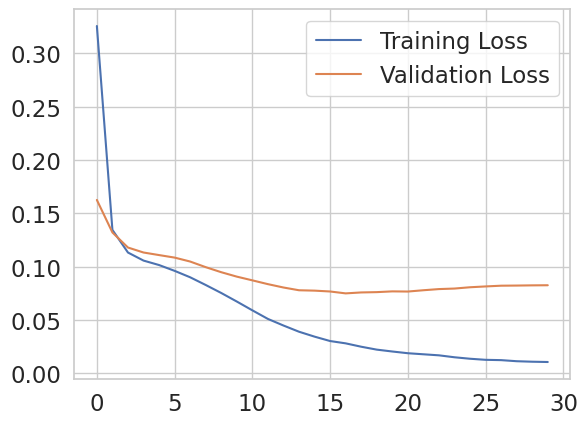

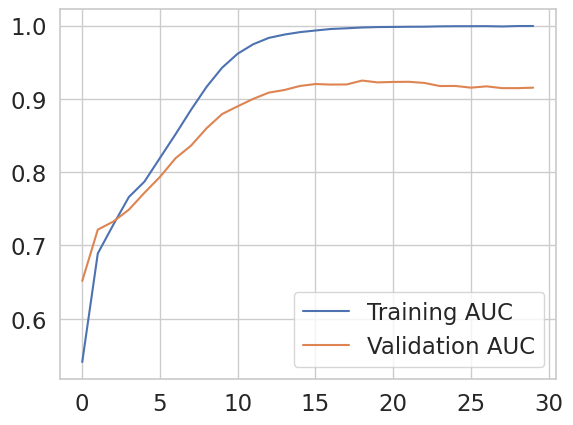

In [61]:
# Plotting losses wrt epochs(time)
plt.plot(history.history["loss"], label="Training Loss") 
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
# Plotting accuracy wrt epochs(time)
plt.plot(history.history["auc_5"], label="Training AUC")
plt.plot(history.history["val_auc_5"], label="Validation AUC")
plt.legend()
plt.show()

In [62]:
metrics = model.evaluate(X_test, y_test)
print("{}: {}".format(model.metrics_names[1], metrics[1]))



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - auc_5: 0.9141 - loss: 0.0749
compile_metrics: 0.9134678840637207


In [66]:
X_test

array([[   0,    0,    0, ..., 2252,   30,   99],
       [   0,    0,    0, ...,  482,   62,  300],
       [   0,    0,    0, ..., 3165, 3381,    3],
       ...,
       [   0,    0,    0, ...,  662,  639,  467],
       [1643, 1561,  492, ...,  471, 2382,  471],
       [   0,    0,    0, ...,  662,  639,  467]], dtype=int32)

In [53]:
#description = "Fits most wrist sizesCompatible with most Apple® iOS and Android cell phones22mm stainless steel bandWater-resistant designAt-a-glance notifications"
prediction = categoryPredictionNN(description)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


[('cep telefonu', 0.52344155),
 ('resim', 0.51482356),
 ('kulaklık', 0.51437926),
 ('samsung', 0.5129658),
 ('corsair', 0.5124939),
 ('elektronik', 0.5113489),
 ('asus', 0.5094845),
 ('apple', 0.50846386),
 ('hoparlörler', 0.50815254),
 ('aksesuarlar', 0.507846)]